In [1]:
import pandas as pd
from io import StringIO

csv_data = '''A,B,C,D
    1.0,2.0,3.0,4.0
    5.0,6.0,,8.0
    0.0,11.0,12.0,'''

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,0.0,11.0,12.0,NaN


In [2]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imp = imp.fit(df)
imputed_data = imp.transform(df.values)
imputed_data

array([[  1. ,   2. ,   3. ,   4. ],
       [  5. ,   6. ,   7.5,   8. ],
       [  0. ,  11. ,  12. ,   6. ]])

In [3]:
import numpy as np
df = pd.DataFrame([
    ['green', 'M', 10.1, 'class1'],
    ['red', 'L', 13.5, 'class2'],
    ['blue', 'XL', 15.3, 'class1']])
df.columns = ['color', 'size', 'price', 'classlabel']
size_mapping = {'XL': 3, 'L': 2, 'M': 1}
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
df['size'] = df['size'].map(size_mapping)
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [4]:
df_wine = pd.read_csv('wine.data', header = None)
df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']
print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

# feature scaling
#scaler = MinMaxScaler()
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [6]:
# L1 regularization
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty = 'l1', C = 0.1)
lr.fit(X_train_norm, y_train)
print('Training accuracy: ', lr.score(X_train_norm, y_train))
print('Test accuracy: ', lr.score(X_test_norm, y_test))

Training accuracy:  0.983870967742
Test accuracy:  0.981481481481


In [7]:
# effect of regularization
weights, params = [], []
for c in np.arange(-4, 6):
    lr = LogisticRegression(penalty = 'l1', C = 10.0**c, random_state = 0)
    lr.fit(X_train_norm, y_train)
    weights.append(lr.coef_[1])
    params.append(10.0**c)
weights =  np.array(weights)

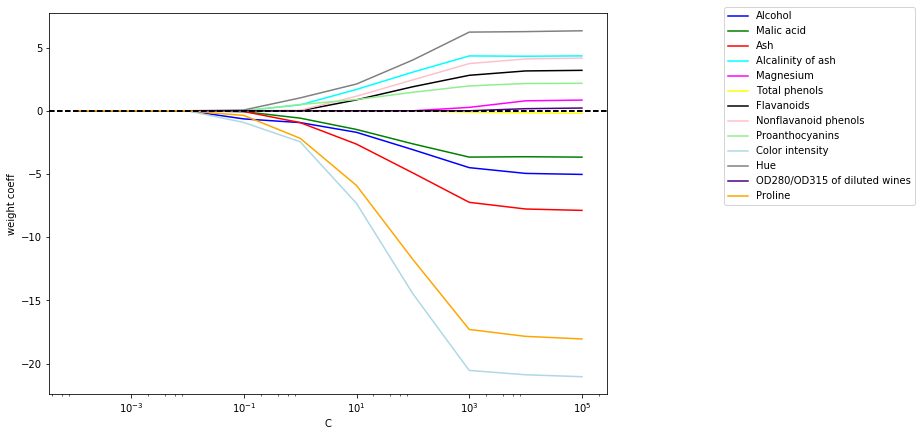

In [8]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 7))
fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'cyan',
          'magenta', 'yellow', 'black',
          'pink', 'lightgreen', 'lightblue',
          'gray', 'indigo', 'orange']
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
            label = df_wine.columns[column + 1],
            color = color)
plt.axhline(0, color = 'black', linestyle = '--', linewidth = 2)
plt.ylabel('weight coeff')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc = 'upper left')
ax.legend(loc = 'upper center',
          bbox_to_anchor = (1.38, 1.03),
          ncol = 1, fancybox = True)
plt.show()

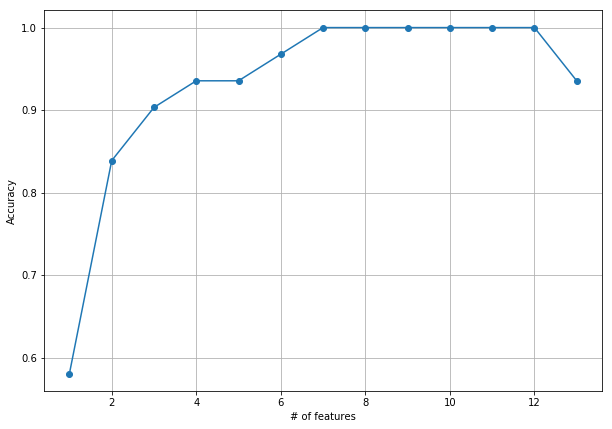

In [9]:
# sequential backward selection
from sklearn.neighbors import KNeighborsClassifier
from sbs import SBS
knn = KNeighborsClassifier(n_neighbors = 2)
sbs = SBS(knn, k_features = 1)
sbs.fit(X_train_norm, y_train)
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker = 'o')
plt.ylabel('Accuracy')
plt.xlabel('# of features')
plt.grid()
plt.show()

In [11]:
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

# KNN on the original set
knn.fit(X_train_norm, y_train)
print('Training accuracy [original]: ', knn.score(X_train_norm, y_train))
print('Test accuracy [original]: ', knn.score(X_test_norm, y_test))

# KNN on the reduced set
knn.fit(X_train_norm[:, k5], y_train)
print('Training accuracy [reduced]: ', knn.score(X_train_norm[:, k5], y_train))
print('Test accuracy [reduced]: ', knn.score(X_test_norm[:, k5], y_test))

Index(['Alcohol', 'Ash', 'Flavanoids', 'Nonflavanoid phenols', 'Hue'], dtype='object')
Training accuracy [original]:  0.983870967742
Test accuracy [original]:  0.944444444444
Training accuracy [reduced]:  0.975806451613
Test accuracy [reduced]:  0.888888888889


In [17]:
from sklearn.ensemble import RandomForestClassifier
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators = 10000, random_state = 0, n_jobs = -1)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10000, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [19]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d. %-*s %f" % (f + 1, 30,
                            feat_labels[f],
                            importances[indices[f]]))

 1. Alcohol                        0.182483
 2. Malic acid                     0.158610
 3. Ash                            0.150948
 4. Alcalinity of ash              0.131987
 5. Magnesium                      0.106589
 6. Total phenols                  0.078243
 7. Flavanoids                     0.060718
 8. Nonflavanoid phenols           0.032033
 9. Proanthocyanins                0.025400
10. Color intensity                0.022351
11. Hue                            0.022078
12. OD280/OD315 of diluted wines   0.014645
13. Proline                        0.013916


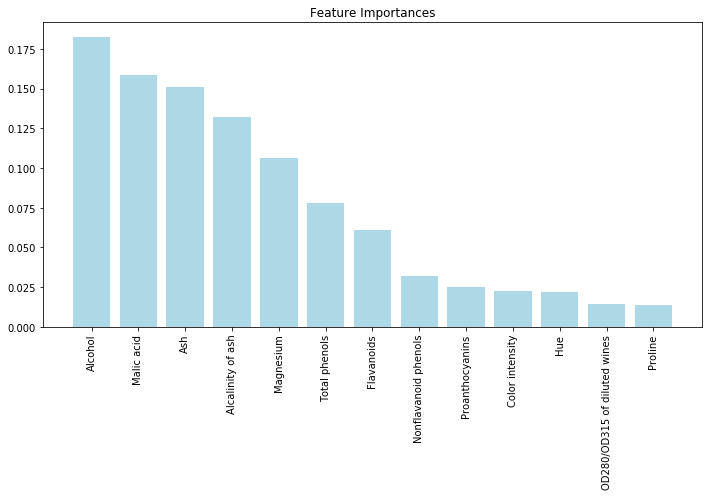

In [24]:
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices],
       color = 'lightblue', align = 'center')
plt.xticks(range(X_train.shape[1]), feat_labels, rotation = 90)
plt.tight_layout()
plt.show()